# Continuous gene expression gradients in the motor cortex

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glmpca import glmpca

from importlib import reload

import gaston
from gaston import neural_net,cluster_plotting, dp_related, segmented_fit, model_selection
from gaston import binning_and_plotting, isodepth_scaling, run_slurm_scripts
from gaston import spatial_gene_classification, plot_cell_types, filter_genes, process_NN_output

## Step 1: Pre-processing

GASTON requires: 
- N x G counts matrix
- N x 2 spatial coordinate matrix,
- list of names for each gene

where N=number of spatial locations and G=number of genes

In [168]:
!mkdir -p motor_cortex_tutorial_outputs

In [2]:
coords_mat=np.load('motor_cortex_data/coords_mat.npy') # N x 2 spatial coordinate matrix 
counts_mat=np.load('motor_cortex_data/counts_mat.npy') # N x G UMI count array
gene_labels=np.load('motor_cortex_data/gene_labels.npy', allow_pickle=True) # array of names of G genes

In [38]:
num_dims=8 # 2 * number of clusters
penalty=10 # may need to increase if this is too small

glmpca_res=glmpca.glmpca(counts_mat.T, num_dims, fam="poi", penalty=penalty, verbose=True)
A = glmpca_res['factors'] # should be of size N x num_dims, where each column is a PC

np.save('motor_cortex_data/glmpca.npy', A)

Iteration: 0 | deviance=7.7347E+5
Iteration: 1 | deviance=7.7347E+5
Iteration: 2 | deviance=6.2336E+5
Iteration: 3 | deviance=4.1521E+5
Iteration: 4 | deviance=3.6895E+5
Iteration: 5 | deviance=3.5008E+5
Iteration: 6 | deviance=3.3981E+5
Iteration: 7 | deviance=3.3384E+5
Iteration: 8 | deviance=3.3011E+5
Iteration: 9 | deviance=3.2758E+5
Iteration: 10 | deviance=3.2573E+5
Iteration: 11 | deviance=3.2431E+5
Iteration: 12 | deviance=3.2318E+5
Iteration: 13 | deviance=3.2227E+5
Iteration: 14 | deviance=3.2151E+5
Iteration: 15 | deviance=3.2088E+5
Iteration: 16 | deviance=3.2035E+5
Iteration: 17 | deviance=3.1990E+5
Iteration: 18 | deviance=3.1951E+5
Iteration: 19 | deviance=3.1918E+5
Iteration: 20 | deviance=3.1888E+5
Iteration: 21 | deviance=3.1862E+5
Iteration: 22 | deviance=3.1839E+5
Iteration: 23 | deviance=3.1818E+5
Iteration: 24 | deviance=3.1799E+5
Iteration: 25 | deviance=3.1782E+5
Iteration: 26 | deviance=3.1766E+5
Iteration: 27 | deviance=3.1751E+5
Iteration: 28 | deviance=3.173

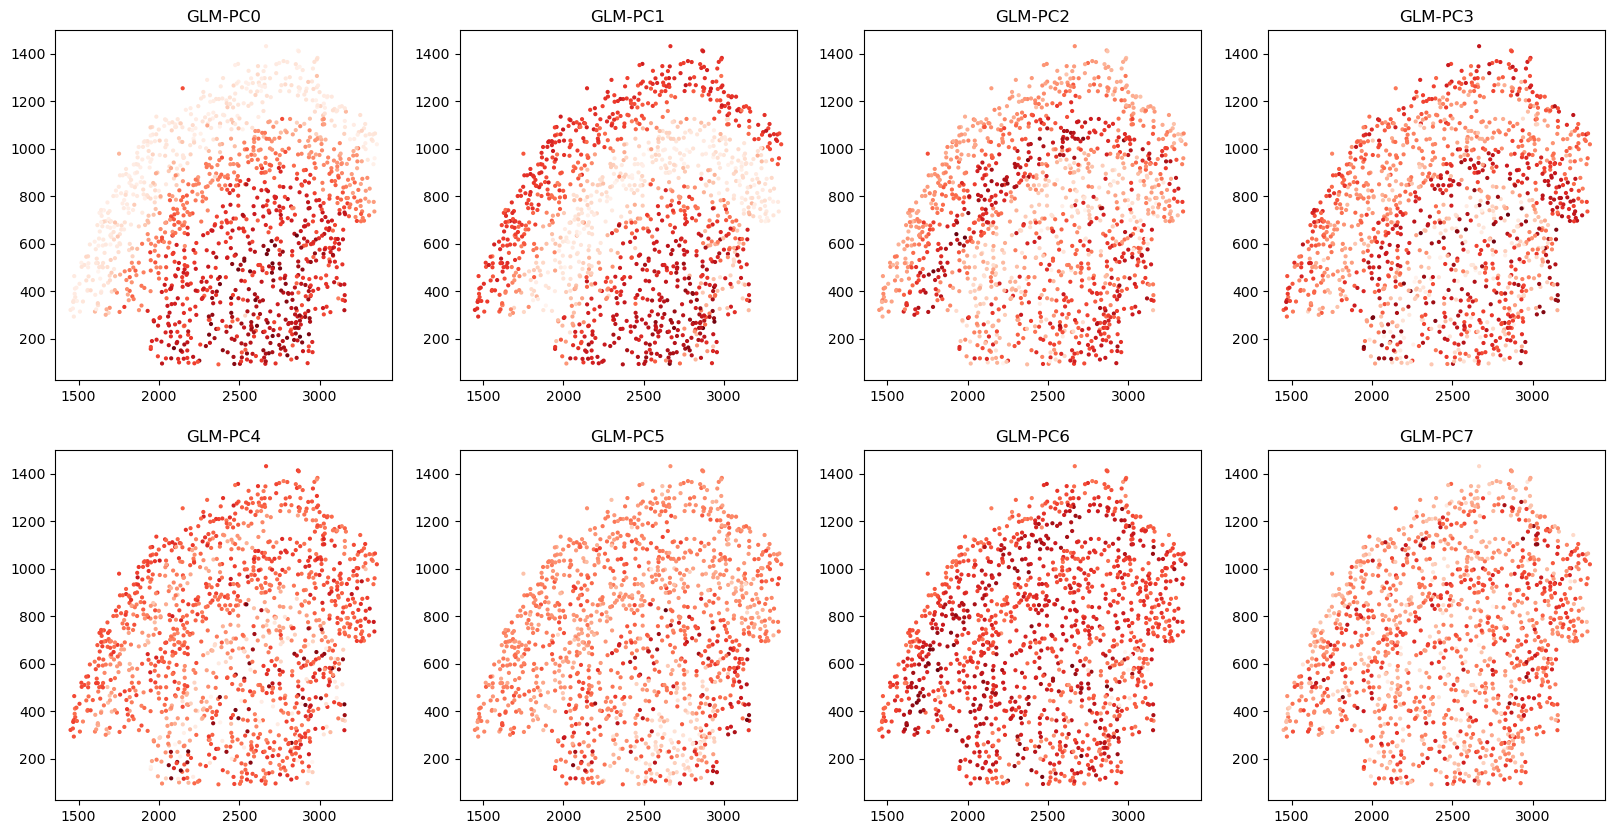

In [19]:
# visualize top GLM-PCs
R=2
C=4
fig,axs=plt.subplots(R,C,figsize=(20,10))
for r in range(R):
    for c in range(C):
        i=r*C+c
        axs[r,c].scatter(coords_mat[:,0], coords_mat[:,1], c=A[:,i],cmap='Reds',s=4)
        axs[r,c].set_title(f'GLM-PC{i}')

## Step 2: Train GASTON neural network

We include how to train the neural network with two options: (1) a command line script and (2) in a notebook. We typically train the neural network 30 different times, each with a different seed, and we use the NN with lowest loss. 

### Option 1: Slurm (Recommended)

For option (1), the code below creates 30 different Slurm jobs, one for each initialization. To train the NN for a single initialization run the following command:

`gaston -i /path/to/coords.npy -o /path/to/glmpca.npy -d /path/to/output_dir -e 10000 -c 500 -p 20 20 -x 20 20 -z adam -s SEED`

for a given `SEED` value (integer)

NOTE: please wait for models to finish training before running below code. You can check on their status by running `squeue -u uchitra` (replacing `uchitra` with your username)

In [41]:
# LOAD DATA generated above
# path_to_glmpca='colorectal_tumor_data/glmpca.npy'
# path_to_coords='colorectal_tumor_data/coords_mat.npy'

# To approximately recreate paper figures, use same GLM-PCs from paper 
path_to_glmpca='motor_cortex_data/glmpca_from_paper.npy'
path_to_coords='motor_cortex_data/coords_mat.npy'

# GASTON NN parameters
isodepth_arch=[20,20] # architecture (two hidden layers of size 20) for isodepth neural network d(x,y)
expression_arch=[20,20] # architecture (two hidden layers of size 20) for 1-D expression function
epochs = 10000 # number of epochs to train NN
checkpoint = 500 # save model after number of epochs = multiple of checkpoint
optimizer = "adam"
num_restarts=30 # number of initializations

output_dir='motor_cortex_tutorial_outputs' # folder to save model runs

# REPLACE with your own conda environment name and path
conda_environment='gaston-package'
path_to_conda_folder='/n/fs/ragr-data/users/uchitra/miniconda3/bin/activate'

run_slurm_scripts.train_NN_parallel(path_to_coords, path_to_glmpca, isodepth_arch, expression_arch, 
                      output_dir, conda_environment, path_to_conda_folder,
                      epochs=epochs, checkpoint=checkpoint, 
                      num_seeds=num_restarts)

jobId: 20487119
jobId: 20487120
jobId: 20487121
jobId: 20487122
jobId: 20487123
jobId: 20487124
jobId: 20487125
jobId: 20487126
jobId: 20487127
jobId: 20487128
jobId: 20487129
jobId: 20487130
jobId: 20487131
jobId: 20487132
jobId: 20487133
jobId: 20487134
jobId: 20487135
jobId: 20487136
jobId: 20487137
jobId: 20487138
jobId: 20487139
jobId: 20487140
jobId: 20487141
jobId: 20487142
jobId: 20487143
jobId: 20487144
jobId: 20487145
jobId: 20487146
jobId: 20487147
jobId: 20487148


### Option 2: train in notebook

In [157]:
path_to_glmpca='motor_cortex_data/glmpca_from_paper.npy'
path_to_coords='motor_cortex_data/coords_mat.npy'

A=np.load(path_to_glmpca) # GLM-PCA results used in manuscript
S=np.load(path_to_coords)

# z-score normalize S and A
S_torch, A_torch = neural_net.load_rescale_input_data(S,A)

In [ ]:
######################################
# NEURAL NET PARAMETERS (USER CAN CHANGE)
# architectures are encoded as list, eg [20,20] means two hidden layers of size 20 hidden neurons
isodepth_arch=[20,20] # architecture for isodepth neural network d(x,y) : R^2 -> R 
expression_fn_arch=[20,20] # architecture for 1-D expression function h(w) : R -> R^G

num_epochs = 10000 # number of epochs to train NN (NOTE: it is sometimes beneficial to train longer)
checkpoint = 500 # save model after number of epochs = multiple of checkpoint
out_dir='motor_cortex_tutorial_outputs' # folder to save model runs
optimizer = "adam"
num_restarts=30

######################################

seed_list=range(num_restarts)
for seed in seed_list:
    print(f'training neural network for seed {seed}')
    out_dir_seed=f"{out_dir}/rep{seed}"
    os.makedirs(out_dir_seed, exist_ok=True)
    mod, loss_list = neural_net.train(S_torch, A_torch,
                          S_hidden_list=isodepth_arch, A_hidden_list=expression_fn_arch, 
                          epochs=num_epochs, checkpoint=checkpoint, 
                          save_dir=out_dir_seed, optim=optimizer, seed=seed, save_final=True)

## Step 3: Process neural network output

We use the model trained for the paper for reproducibility. If you use the model trained above, then figures will closely match the manuscript --- but not exactly match --- due to PyTorch non-determinism in seeding (see https://github.com/pytorch/pytorch/issues/7068 ). 

### Visualize isodepth (topographic map) and spatial domains

Load best model

In [7]:
#gaston_model, A, S=process_NN_output.process_files('motor_cortex_tutorial_outputs')  # model trained above
gaston_model, A, S= process_NN_output.process_files('motor_cortex_data/reproduce_motor_cortex') # MATCH PAPER FIGURES

coords_mat=np.load('motor_cortex_data/coords_mat.npy') # N x 2 spatial coordinate matrix 
counts_mat=np.load('motor_cortex_data/counts_mat.npy') # N x G UMI count array
gene_labels=np.load('motor_cortex_data/gene_labels.npy', allow_pickle=True) # array of names of G genes

best model: motor_cortex_data/reproduce_motor_cortex/seed15


Kneedle number of domains: 4


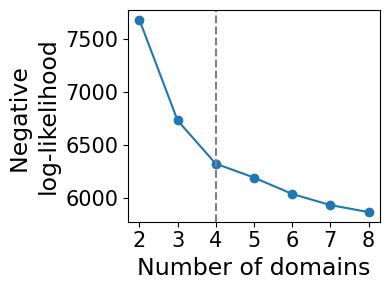

In [8]:
model_selection.plot_ll_curve(gaston_model, A, S, max_domain_num=8, start_from=2)

Compute isodepth and GASTON domains 

In [9]:
num_layers=4 # CHANGE FOR YOUR APPLICATION: use number of layers from above!
gaston_isodepth, gaston_labels=dp_related.get_isodepth_labels(gaston_model,A,S,num_layers)

In [10]:
gaston_isodepth=isodepth_scaling.adjust_isodepth(gaston_isodepth, gaston_labels, coords_mat, 
                                 q_vals=[0.1, 0.15, 0.2, 0.2], scale_factor=0.05)

Plot topographic map: isodepth and spatial gradients

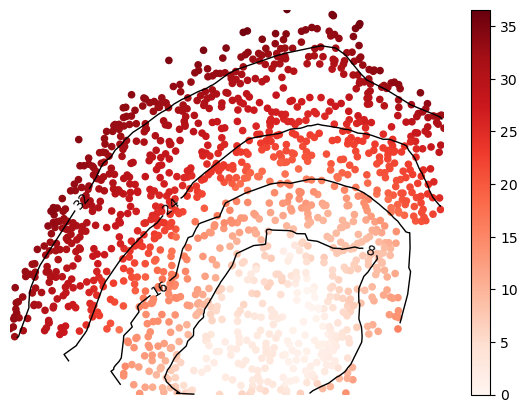

In [11]:
show_streamlines=False
cluster_plotting.plot_isodepth(gaston_isodepth, S, gaston_model, figsize=(7,5), streamlines=show_streamlines, streamlines_lw=0.3, cmap="Reds")

Plot GASTON domains

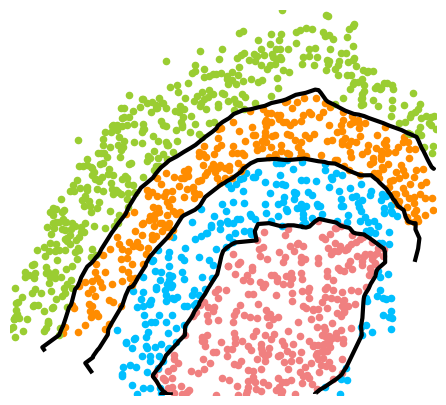

In [12]:
domain_colors=['lightcoral', 'deepskyblue', 'darkorange', 'yellowgreen']
cluster_plotting.plot_clusters(gaston_labels, S, figsize=(5.5,5), 
                               colors=domain_colors, s=20, lgd=False, 
                               show_boundary=True, gaston_isodepth=gaston_isodepth, boundary_lw=3)

## Continuous gradient analysis

Compute piecewise linear fit for every gene 

In [13]:
umi_threshold = 0
pw_fit_dict=segmented_fit.pw_linear_fit(counts_mat, gaston_labels, gaston_isodepth,
    None, [], umi_threshold = umi_threshold)

Poisson regression for ALL cell types


100%|██████████| 242/242 [00:06<00:00, 35.41it/s]


In [14]:
binning_output=binning_and_plotting.bin_data(counts_mat, gaston_labels, gaston_isodepth, 
    None, gene_labels, num_bins_per_domain=[7,7,5,6], umi_threshold=umi_threshold, remove_unused_bins=True, min_cells_per_bin=8)

Find discontinuous and continuous genes

In [15]:
q=0.9 # use 0.9 quantile for slopes, discontinuities
discont_genes_layer=spatial_gene_classification.get_discont_genes(pw_fit_dict, binning_output,q=q)
cont_genes_layer=spatial_gene_classification.get_cont_genes(pw_fit_dict, binning_output,q=q)

Visualize piecewise linear fits

gene Wipf3: discontinuous after domain(s) []
gene Wipf3: continuous in domain(s) []


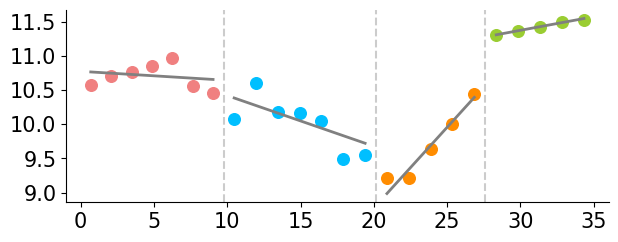

In [16]:
gene_name='Wipf3'
print(f'gene {gene_name}: discontinuous after domain(s) {discont_genes_layer[gene_name]}') 
print(f'gene {gene_name}: continuous in domain(s) {cont_genes_layer[gene_name]}')

# display log CPM (if you want to do CP500, set offset=500)
offset=10**6

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, 
                                        binning_output, cell_type_list=None, pt_size=70, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(7,2.5), offset=offset, lw=2,
                                       domain_boundary_plotting=True)

Visualize raw expression values and piecewise linear function learned by GASTON

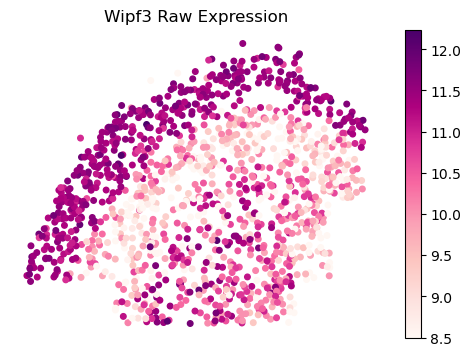

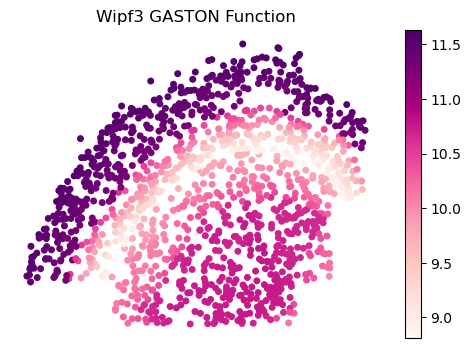

In [17]:
binning_and_plotting.plot_gene_raw(gene_name, gene_labels, counts_mat, S, vmin=8.5, figsize=(6,4))
plt.title(f'{gene_name} Raw Expression')
binning_and_plotting.plot_gene_function(gene_name, S, pw_fit_dict, gaston_labels, gaston_isodepth, binning_output, figsize=(6,4))
plt.title(f'{gene_name} GASTON Function')
plt.show()

gene Camk2d: discontinuous after domain(s) [0]
gene Camk2d: continuous in domain(s) [1]


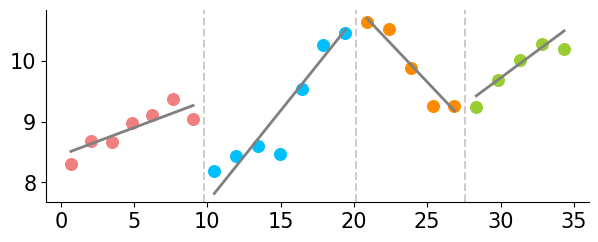

In [18]:
gene_name='Camk2d'
print(f'gene {gene_name}: discontinuous after domain(s) {discont_genes_layer[gene_name]}') 
print(f'gene {gene_name}: continuous in domain(s) {cont_genes_layer[gene_name]}')

# display log CPM (if you want to do CP500, set offset=500)
offset=10**6

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, 
                                        binning_output, cell_type_list=None, pt_size=70, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(7,2.5), offset=offset, lw=2,
                                       domain_boundary_plotting=True)

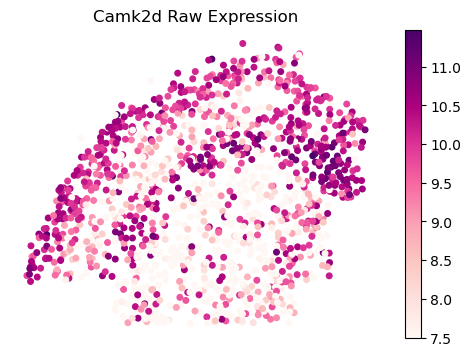

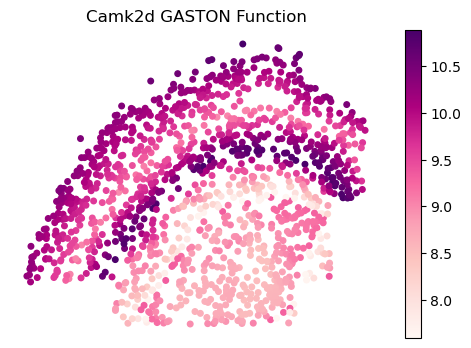

In [19]:
binning_and_plotting.plot_gene_raw(gene_name, gene_labels, counts_mat, S, vmin=7.5, figsize=(6,4))
plt.title(f'{gene_name} Raw Expression')
binning_and_plotting.plot_gene_function(gene_name, S, pw_fit_dict, gaston_labels, gaston_isodepth, binning_output, figsize=(6,4))
plt.title(f'{gene_name} GASTON Function')
plt.show()

gene Marcksl1: discontinuous after domain(s) []
gene Marcksl1: continuous in domain(s) [1, 2]


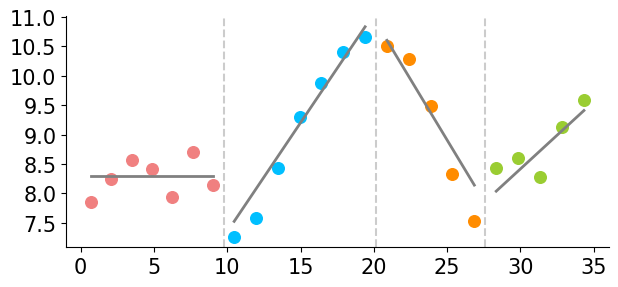

In [20]:
gene_name='Marcksl1'
print(f'gene {gene_name}: discontinuous after domain(s) {discont_genes_layer[gene_name]}') 
print(f'gene {gene_name}: continuous in domain(s) {cont_genes_layer[gene_name]}')

# display log CPM (if you want to do CP500, set offset=500)
offset=10**6

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels, gaston_isodepth, 
                                        binning_output, cell_type_list=None, pt_size=70, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(7,3), offset=offset, lw=2,
                                       domain_boundary_plotting=True)

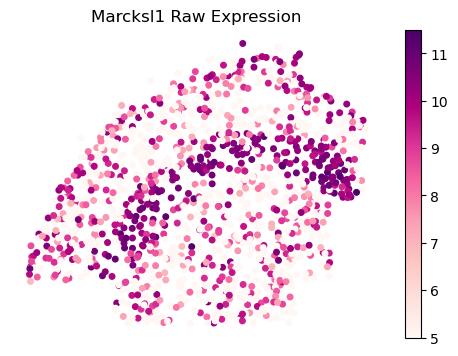

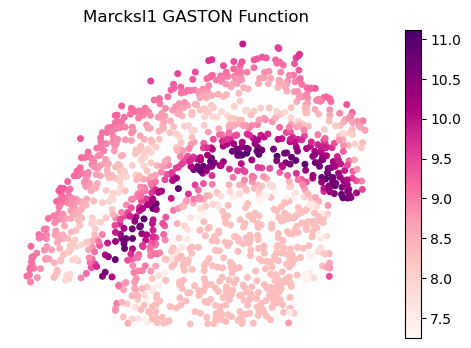

In [21]:
binning_and_plotting.plot_gene_raw(gene_name, gene_labels, counts_mat, S, vmin=5, figsize=(6,4))
plt.title(f'{gene_name} Raw Expression')
binning_and_plotting.plot_gene_function(gene_name, S, pw_fit_dict, gaston_labels, gaston_isodepth, binning_output, figsize=(6,4))
plt.title(f'{gene_name} GASTON Function')
plt.show()